In [1]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import random
%matplotlib inline
# %matplotlib notebook


def load_data(infile, band=1):
    ds = gdal.Open(infile, gdal.GA_ReadOnly)
    # Data array
    data = ds.GetRasterBand(band).ReadAsArray()
    # Map extent
    trans = ds.GetGeoTransform()
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    extent = [trans[0], trans[0] + xsize * trans[1],
              trans[3] + ysize*trans[5], trans[3]]
    ds = None
    return data, extent


def plot_data(data, extent, cmap, title):
    plt.figure()
    plt.imshow(data, extent=extent, cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.show()


def get_date(disp_names):
    date = []
    for n in disp_names:
        date.append(re.findall(r'\d{8}', n)[0])
    return date


def get_cum_disp(path):
    # get disp_geo file name
    disp_names = sorted([i for i in os.listdir(path) if i.endswith('disp_geo')])
    # get extent
    disp, extent = load_data(os.path.join(path, disp_names[1]))
    # generate lon,lat
    lon = np.linspace(extent[0], extent[1], disp.shape[1])
    lat = np.linspace(extent[3], extent[2], disp.shape[0])
    lons, lats = np.meshgrid(lon, lat)

    not_nan = (~np.isnan(disp))
    # reshape array
    lons = lons[not_nan].reshape((-1, 1))
    lats = lats[not_nan].reshape((-1, 1))
    # generate point ID
    num = np.arange(0, lons.shape[0]).reshape((-1, 1))
    # get 4 colums data (num lon lat disp)
    cum_disp = np.concatenate([num, lons, lats], axis=1)
    for disp_name in disp_names:
        disp_path = os.path.join(path, disp_name)
        disp, _ = load_data(disp_path)
        disp = disp[not_nan].reshape((-1, 1))
        cum_disp = np.concatenate([cum_disp, disp], axis=1)
    return disp_names, extent, cum_disp, num, lons, lats


def random_downsample(data, percent):
    point_num = data.shape[0]
    index = random.sample(range(point_num), int(point_num * percent))
    return data[index, :]


def plot_point_disp(cum_disp, date, num_list, y_lim, flag=False):
    cum_disp = np.asarray(cum_disp, dtype=np.float16)
    point_disp = []
    for num in num_list:
        if num >= cum_disp.shape[0] or num < 0:
            print('Error: cannot find point {}\n'.format(num))
        else:
            line = cum_disp[num, :]
            plt.figure(figsize=(10, 5))
            point_disp.append(list(line))
            plt.plot(date, line[3:])
            plt.grid(True)
            plt.xticks(rotation=40)
            plt.ylim(y_lim)
            plt.title('Point {}'.format(num))
            plt.xlabel('date', fontsize=14)
            plt.ylabel('cumulative displacement (mm)', fontsize=14)
            if flag:
                plt.savefig('cum_disp_{}.png'.format(num), dpi=300)
            plt.show()
    # for i in point_disp:
    #     print('{}\n'.format(i))


def plot_point_disp_in_one(cum_disp, date, num_list, y_lim, flag=False):
    cum_disp = np.asarray(cum_disp, dtype=np.float16)
    point_disp = []
    plt.figure(figsize=(18, 6))
    for num in num_list:
        if num >= cum_disp.shape[0] or num < 0:
            print('Error: cannot find point {}\n'.format(num))
        else:
            line = cum_disp[num, :]
            point_disp.append(list(line))
            plt.plot(date, line[3:], label=str(num))
            plt.grid(True)
            plt.xticks(rotation=40)
            plt.ylim(y_lim)
            plt.legend()
            plt.title('Point displacement')
            plt.xlabel('date', fontsize=14)
            plt.ylabel('cumulative displacement (mm)', fontsize=14)
    if flag:
        plt.savefig('cum_disp.png', dpi=300)
    plt.show()
    # for i in point_disp:
    #     print('{}\n'.format(i))

## 读取累计形变数据并绘图

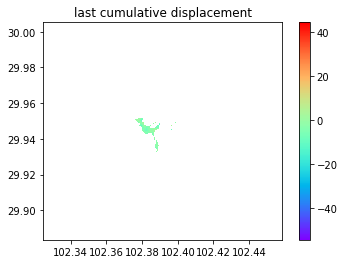

In [2]:
path = r'C:\thorly\Files\landslide\9_SBAS_processing\inversion\geocoded'

disp_names, extent, cum_disp, num, lons, lats = get_cum_disp(path)
# os.chdir(path)
# np.savetxt('cumulative_disp.txt', cum_disp, fmt='%4f')
# get last cumulative displacement
last_cum_disp, extent = load_data(os.path.join(path, disp_names[-1]))
plot_data(data=last_cum_disp, extent=extent, cmap='rainbow', title='last cumulative displacement')

## 平均速率图随机降采样

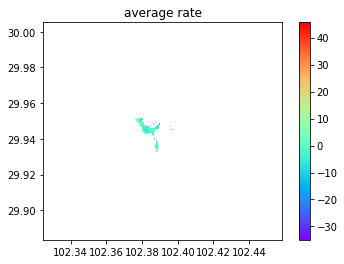

In [34]:
average_rate, extent = load_data(os.path.join(path, "SI_vel_geo"))

plot_data(data=average_rate, extent=extent, cmap='rainbow', title='average rate')

not_nan = (~np.isnan(average_rate))
average_rate = average_rate[not_nan].reshape((-1, 1))

save_data = np.hstack((num, lons, lats, average_rate))
# downsample
downsample_data = random_downsample(save_data, 0.7)
# save average velocity rate
os.chdir(os.path.dirname(os.path.dirname(path)))
np.savetxt('average_rate_sample9.txt', downsample_data, fmt='%4f')

## 绘制累计形变趋势图

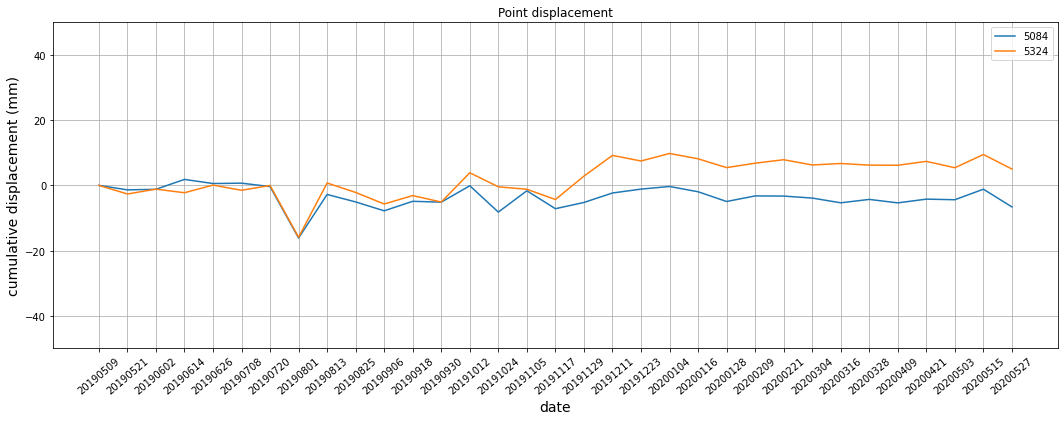

In [7]:
# path = r'C:\thorly\Files\landslide\9_SBAS_processing\inversion\geocoded'
# disp_names, extent, cum_disp, num, lons, lats = get_cum_disp(path)
# last_cum_disp, extent = load_data(os.path.join(path, disp_names[-1]))

date = get_date(disp_names)
# num_list = sorted([4348, 4466, 4465, 3789, 5154, 4781, 3687])
# num_list = sorted([3484, 3562])
num_list = sorted([5324, 5084])
# num_list = sorted([5204, 5142, 5143, 5310, 4781])
plot_point_disp_in_one(cum_disp, date, num_list, [-50, 50], True)

